In [216]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import defaultdict
from scipy.cluster.hierarchy import dendrogram, linkage

In [217]:
from tpot import TPOTRegressor

In [324]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import RepeatedKFold, cross_val_score, KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer, StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFpr, f_classif, mutual_info_classif

In [14]:
k10 = KFold(n_splits=10, shuffle=True, random_state=123)
k5 = KFold(n_splits=5, shuffle=True, random_state=123)

In [15]:
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(RMSE, greater_is_better=False)

In [16]:
x_train = pd.read_csv('datasets/solubility/solTrainXtrans.csv', index_col=0).reset_index(drop=True)
y_train = pd.read_csv('datasets/solubility/solTrainY.csv', index_col=0).values.ravel()

In [17]:
x_train.head()

,FP001,FP002,FP003,FP004,FP005,FP006,FP007,FP008,FP009,FP010,...,NumCarbon,NumNitrogen,NumOxygen,NumSulfer,NumChlorine,NumHalogen,NumRings,HydrophilicFactor,SurfaceArea1,SurfaceArea2
0,0,1,0,0,1,0,0,1,0,0,...,4.177811,0.584815,0.000000,-0.000,-0.000,-0.000,1.386294,-1.606542,6.812456,6.812456
1,0,1,0,1,1,1,1,1,0,0,...,5.092358,0.642355,0.693147,0.375,-0.000,-0.000,1.609438,-0.441330,9.753834,12.029604
2,1,1,1,1,1,0,0,1,0,1,...,4.023944,-0.000000,1.098612,-0.000,-0.000,-0.000,0.693147,-0.384859,8.245324,8.245324
3,0,0,1,0,0,0,1,0,0,0,...,3.510455,-0.000000,0.000000,-0.000,-0.000,-0.000,0.693147,-2.373472,0.000000,0.000000
4,0,0,1,1,1,1,0,0,1,0,...,3.317541,0.694335,0.000000,-0.000,0.375,0.375,0.693147,-0.070987,9.913535,9.913535


In [18]:
x_shuffle = x_train.copy()
for c in x_shuffle.columns[:-1]:
    x_shuffle[c] = np.random.permutation(x_shuffle[c])

In [19]:
x_shuffle.head()

,FP001,FP002,FP003,FP004,FP005,FP006,FP007,FP008,FP009,FP010,...,NumCarbon,NumNitrogen,NumOxygen,NumSulfer,NumChlorine,NumHalogen,NumRings,HydrophilicFactor,SurfaceArea1,SurfaceArea2
0,0,1,0,1,1,1,0,0,0,0,...,2.068855,-0.000000,1.609438,-0.0,-0.0,-0.0,0.000000,0.148868,10.102965,6.812456
1,0,0,0,0,0,1,1,0,0,0,...,3.110607,-0.000000,1.098612,-0.0,-0.0,-0.0,1.098612,-1.512881,5.986332,12.029604
2,1,1,0,1,1,1,0,0,0,0,...,2.886887,0.584815,1.609438,-0.0,-0.0,-0.0,1.386294,-0.425521,5.999109,8.245324
3,0,0,0,1,1,1,0,0,1,0,...,3.510455,0.456826,1.386294,-0.0,-0.0,-0.0,0.693147,-1.990493,0.000000,0.000000
4,0,0,0,0,1,0,0,0,1,0,...,3.862179,-0.000000,1.791759,-0.0,-0.0,-0.0,0.000000,-1.990493,10.596388,9.913535


In [23]:
lin = LinearRegression(normalize=False)
#lasso = GridSearchCV(Lasso(normalize=True), {'alpha':[.001, .01, .1, 1]}, cv=k5, scoring=rmse_scorer)
#pls = GridSearchCV(PLSRegression(), {'n_components':[2, 5, 10, 15]}, cv=k5, scoring=rmse_scorer)
#svr = GridSearchCV(SVR(kernel='rbf'), {"C":[.001, .01, .1, 1, 10, 100]}, cv=k5, scoring=rmse_scorer)
#tree = GridSearchCV(DecisionTreeRegressor(), {'max_depth':[None, 3, 5, 7, 9]}, cv=k5, scoring=rmse_scorer)
#rf = GridSearchCV(RandomForestRegressor(), 
#                  {'max_depth': [None, 3, 5, 7, 9], 'n_estimators':[10, 100, 200]}, cv=k5, scoring=rmse_scorer)
lasss = Lasso(normalize=True)
pls = PLSRegression(n_components=10)
svr = SVR()
tree = DecisionTreeRegressor(max_depth=5, random_state=123)
rf = RandomForestRegressor(n_estimators=50)

In [24]:
add_list = [0, 10, 50, 100, 200, 300, 400, 500]

In [25]:
%%time
result = defaultdict(list)

models = [lin, lasso, pls, svr, tree, rf]
model_names = ['LinearRegression', 'Lasso', 'PLS', 'SVR', 'Tree', 'RandomForest']

for n in add_list:
    print('n={}'.format(n), end=' ')
    if not n:
        x_add = x_train
    else:
        x_add = pd.concat([x_train, x_shuffle.sample(n=n, replace=True, axis=1)], axis=1)
    for model, name in zip(models, model_names):
            score = -cross_val_score(model, x_add, y_train, cv=k10, scoring=rmse_scorer).mean()
            result[name].append(score)

n=0 n=10 n=50 n=100 n=200 n=300 n=400 n=500 CPU times: user 9min 30s, sys: 2.05 s, total: 9min 32s
Wall time: 7min 36s


(0.5, 1.3)

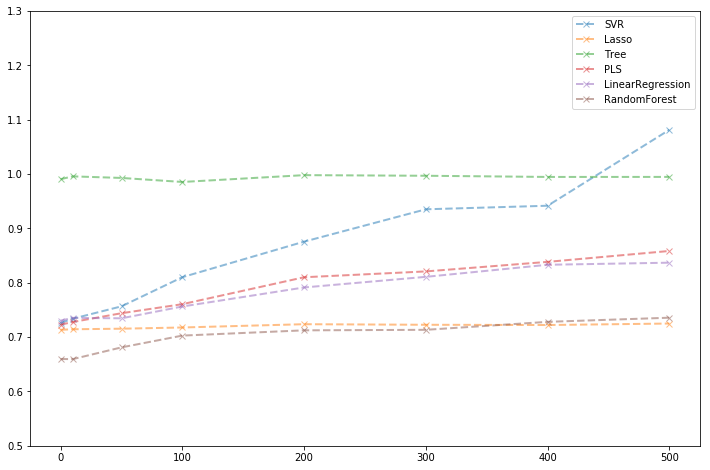

In [27]:
plt.figure(figsize=(12, 8))
for k, v in result.items():
    plt.plot(add_list, v, 'x--', label=k, alpha=.5, linewidth=2)
plt.legend()
plt.ylim([.5, 1.3])

In [32]:
tpot_reg = TPOTRegressor(generations=5, population_size=20, verbosity=2)

/home/pongsakorn/anaconda3/envs/py35/lib/python3.5/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/pongsakorn/anaconda3/envs/py35/lib/python3.5/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [33]:
tpot_reg.fit(x_train, y_train)

Optimization Progress:  33%|███▎      | 40/120 [02:28<02:58,  2.23s/pipeline]

Generation 1 - Current best internal CV score: 0.5421948415097326


Optimization Progress:  50%|█████     | 60/120 [03:43<02:21,  2.36s/pipeline]

Generation 2 - Current best internal CV score: 0.5421948415097326


Optimization Progress:  67%|██████▋   | 80/120 [05:19<03:00,  4.52s/pipeline]

Generation 3 - Current best internal CV score: 0.538617808771308


Optimization Progress:  83%|████████▎ | 100/120 [06:36<01:28,  4.41s/pipeline]

Generation 4 - Current best internal CV score: 0.5374434880728935


Generation 5 - Current best internal CV score: 0.5374434880728935

Best pipeline: ElasticNetCV(input_matrix, l1_ratio=0.35, tol=0.01)


TPOTRegressor(config_dict={'sklearn.preprocessing.StandardScaler': {}, 'sklearn.feature_selection.SelectPercentile': {'score_func': {'sklearn.feature_selection.f_regression': None}, 'percentile': range(1, 100)}, 'sklearn.ensemble.GradientBoostingRegressor': {'min_samples_split': range(2, 21), 'max_depth': range(1... 0.7 ,  0.75,  0.8 ,  0.85,
        0.9 ,  0.95,  1.  ])}, 'sklearn.preprocessing.MaxAbsScaler': {}},
       crossover_rate=0.1, cv=5, disable_update_check=False,
       early_stop=None, generations=5, max_eval_time_mins=5,
       max_time_mins=None, memory=None, mutation_rate=0.9, n_jobs=1,
       offspring_size=20, periodic_checkpoint_folder=None,
       population_size=20, random_state=None, scoring=None, subsample=1.0,
       verbosity=2, warm_start=False)

In [38]:
best_pipe = tpot_reg.fitted_pipeline_

In [39]:
best_pipe.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('elasticnetcv', ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=0.35000000000000003, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.01, verbose=0))])

In [40]:
scores = cross_val_score(best_pipe, x_train, y_train, scoring=rmse_scorer, cv=k10)

In [41]:
-scores.mean()

0.6747673925648906

### Case Study: Predicting Cognitive Impairment

In [199]:
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFECV, f_classif, f_oneway

In [134]:
# 5 repeated 10-fold cross-validation
five10k = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)

# 10-fold cross-validation
k10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [135]:
data_y = pd.read_csv('datasets/AlzheimerDisease/diagnosis.csv', index_col=0)
data = pd.read_csv('datasets/AlzheimerDisease/predictors.csv', index_col=0)

In [136]:
data_y.head()

,0
0,Control
1,Control
2,Control
3,Control
4,Control


In [137]:
data.head()

,ACE_CD143_Angiotensin_Converti,ACTH_Adrenocorticotropic_Hormon,AXL,Adiponectin,Alpha_1_Antichymotrypsin,Alpha_1_Antitrypsin,Alpha_1_Microglobulin,Alpha_2_Macroglobulin,Angiopoietin_2_ANG_2,Angiotensinogen,...,VCAM_1,VEGF,Vitronectin,von_Willebrand_Factor,age,tau,p_tau,Ab_42,male,Genotype
1,2.003100,-1.386294,1.098387,-5.360193,1.740466,-12.631361,-2.577022,-72.650290,1.064711,2.510547,...,3.258097,22.034564,-0.040822,-3.146555,0.987624,6.297754,4.348108,12.019678,0.0,E3E3
2,1.561856,-1.386294,0.683282,-5.020686,1.458615,-11.909882,-3.244194,-154.612278,0.741937,2.457283,...,2.708050,18.601843,-0.385662,-3.863233,0.986150,6.659294,4.859967,11.015759,0.0,E3E4
3,1.520660,-1.714798,-0.145276,-5.809143,1.193922,-13.642963,-2.882404,-136.529178,0.832909,1.976365,...,2.639057,17.476191,-0.223144,-3.540459,0.986667,6.270988,4.400247,12.302271,1.0,E3E4
4,1.680826,-1.609438,0.683282,-5.115996,1.280934,-15.523564,-3.170086,-98.361752,0.916291,2.376085,...,2.772589,17.545595,-0.653926,-3.863233,0.986702,6.152733,4.494886,12.398138,0.0,E3E4
5,2.400931,-0.967584,0.190890,-4.779524,2.128232,-11.133063,-2.343407,-144.944601,0.955511,2.862219,...,3.044522,20.778602,0.166216,-3.816713,0.987163,6.623707,4.524589,11.024109,0.0,E3E3


In [138]:
data['diagnosis'] = data_y.values

In [139]:
data.head()

,ACE_CD143_Angiotensin_Converti,ACTH_Adrenocorticotropic_Hormon,AXL,Adiponectin,Alpha_1_Antichymotrypsin,Alpha_1_Antitrypsin,Alpha_1_Microglobulin,Alpha_2_Macroglobulin,Angiopoietin_2_ANG_2,Angiotensinogen,...,VEGF,Vitronectin,von_Willebrand_Factor,age,tau,p_tau,Ab_42,male,Genotype,diagnosis
1,2.003100,-1.386294,1.098387,-5.360193,1.740466,-12.631361,-2.577022,-72.650290,1.064711,2.510547,...,22.034564,-0.040822,-3.146555,0.987624,6.297754,4.348108,12.019678,0.0,E3E3,Control
2,1.561856,-1.386294,0.683282,-5.020686,1.458615,-11.909882,-3.244194,-154.612278,0.741937,2.457283,...,18.601843,-0.385662,-3.863233,0.986150,6.659294,4.859967,11.015759,0.0,E3E4,Control
3,1.520660,-1.714798,-0.145276,-5.809143,1.193922,-13.642963,-2.882404,-136.529178,0.832909,1.976365,...,17.476191,-0.223144,-3.540459,0.986667,6.270988,4.400247,12.302271,1.0,E3E4,Control
4,1.680826,-1.609438,0.683282,-5.115996,1.280934,-15.523564,-3.170086,-98.361752,0.916291,2.376085,...,17.545595,-0.653926,-3.863233,0.986702,6.152733,4.494886,12.398138,0.0,E3E4,Control
5,2.400931,-0.967584,0.190890,-4.779524,2.128232,-11.133063,-2.343407,-144.944601,0.955511,2.862219,...,20.778602,0.166216,-3.816713,0.987163,6.623707,4.524589,11.024109,0.0,E3E3,Control


In [140]:
data['diagnosis'].value_counts()

Control     242
Impaired     91
Name: diagnosis, dtype: int64

In [141]:
data['diagnosis'] = data['diagnosis'].map({'Control':0, 'Impaired':1})

In [142]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333 entries, 1 to 333
Columns: 131 entries, ACE_CD143_Angiotensin_Converti to diagnosis
dtypes: float64(127), int64(3), object(1)
memory usage: 343.4+ KB


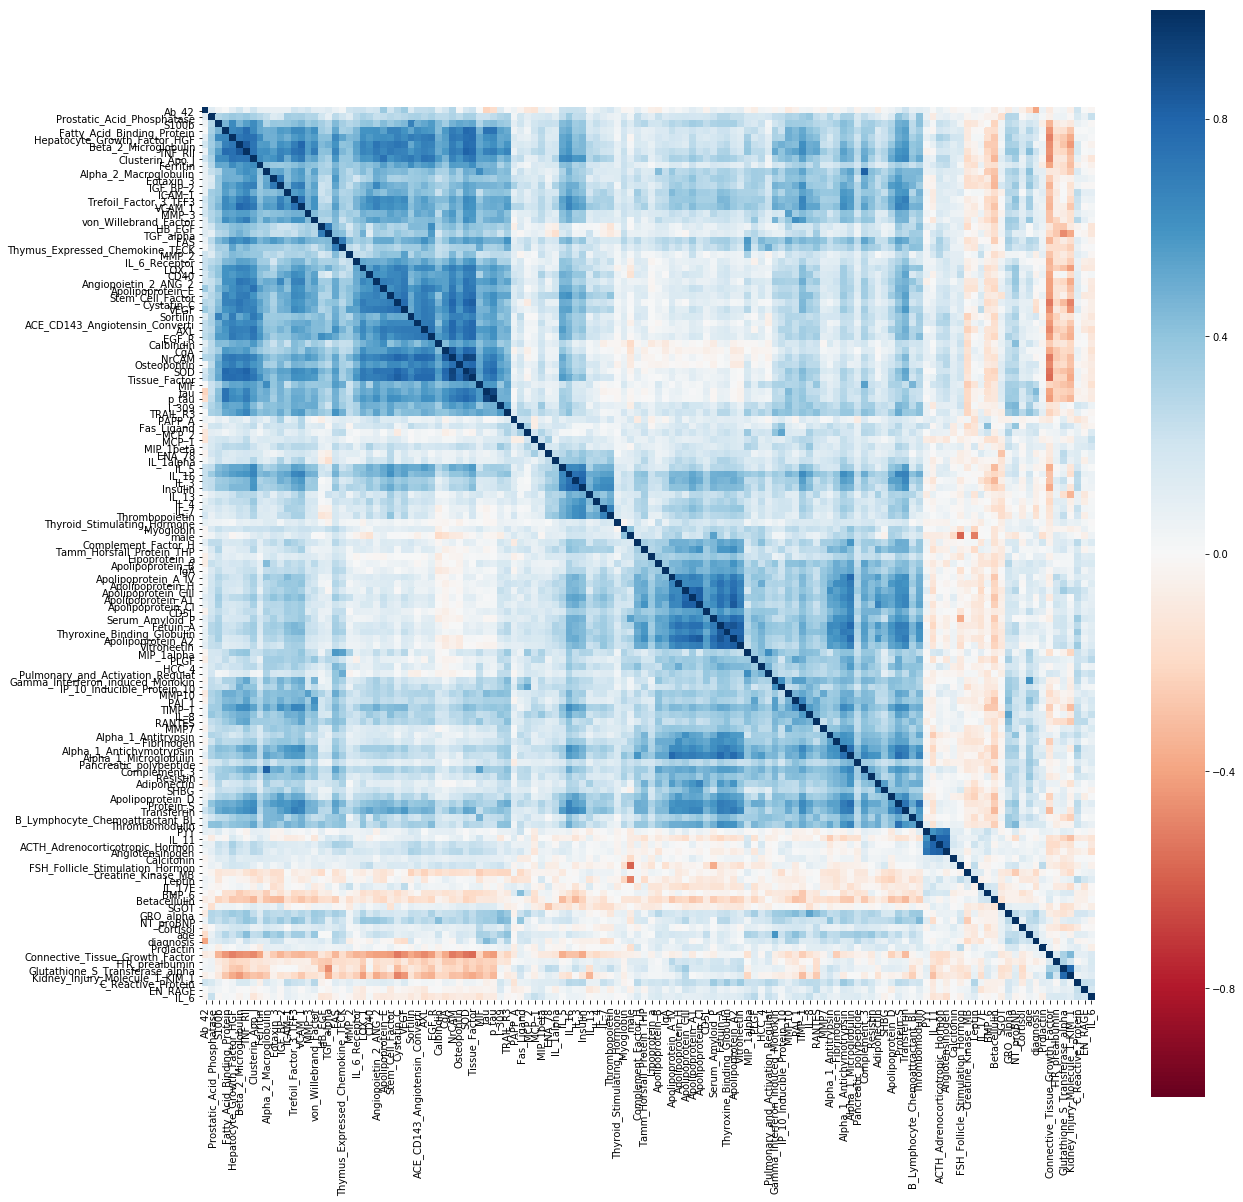

In [143]:
corr = data.corr()
Z = linkage(corr, method='complete', metric='correlation')
Y = dendrogram(Z, no_plot=True)['leaves']
corr = corr.iloc[:, Y]
corr = corr.iloc[Y, :]

fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, square=True, annot=False, vmax=1, vmin=-1, cmap='RdBu', xticklabels=True, yticklabels=True, ax=ax)

In [144]:
a1, a2 = np.triu_indices(n=corr.shape[0], k=1, m=corr.shape[1])

pd.Series(corr.values[a1, a2]).describe()

count    8385.000000
mean        0.202944
std         0.217704
min        -0.592293
25%         0.052416
50%         0.182501
75%         0.345361
max         0.922976
dtype: float64

In [145]:
data['Genotype'].value_counts()

E3E3    167
E3E4    106
E2E3     37
E4E4     13
E2E4      8
E2E2      2
Name: Genotype, dtype: int64

In [146]:
# dummy Genotype feature
c1 = sorted(data['Genotype'].unique())
c2 = ['E2', 'E3', 'E4']



mb = MultiLabelBinarizer(classes=c2)
lb = LabelBinarizer()



tmp = np.hstack([lb.fit_transform(data['Genotype']), 
                 mb.fit_transform(data['Genotype'].map(lambda x: [x[:2], x[2:]]))])
tmp = pd.DataFrame(tmp, columns=c1 + c2, index=data.index)

data = pd.concat([data, tmp], axis=1)
data.drop('Genotype', axis=1, inplace=True)

In [147]:
list(data.columns)

['ACE_CD143_Angiotensin_Converti',
 'ACTH_Adrenocorticotropic_Hormon',
 'AXL',
 'Adiponectin',
 'Alpha_1_Antichymotrypsin',
 'Alpha_1_Antitrypsin',
 'Alpha_1_Microglobulin',
 'Alpha_2_Macroglobulin',
 'Angiopoietin_2_ANG_2',
 'Angiotensinogen',
 'Apolipoprotein_A_IV',
 'Apolipoprotein_A1',
 'Apolipoprotein_A2',
 'Apolipoprotein_B',
 'Apolipoprotein_CI',
 'Apolipoprotein_CIII',
 'Apolipoprotein_D',
 'Apolipoprotein_E',
 'Apolipoprotein_H',
 'B_Lymphocyte_Chemoattractant_BL',
 'BMP_6',
 'Beta_2_Microglobulin',
 'Betacellulin',
 'C_Reactive_Protein',
 'CD40',
 'CD5L',
 'Calbindin',
 'Calcitonin',
 'CgA',
 'Clusterin_Apo_J',
 'Complement_3',
 'Complement_Factor_H',
 'Connective_Tissue_Growth_Factor',
 'Cortisol',
 'Creatine_Kinase_MB',
 'Cystatin_C',
 'EGF_R',
 'EN_RAGE',
 'ENA_78',
 'Eotaxin_3',
 'FAS',
 'FSH_Follicle_Stimulation_Hormon',
 'Fas_Ligand',
 'Fatty_Acid_Binding_Protein',
 'Ferritin',
 'Fetuin_A',
 'Fibrinogen',
 'GRO_alpha',
 'Gamma_Interferon_induced_Monokin',
 'Glutathione_

### 20% stratified holdout set

In [148]:
train, test = train_test_split(data, test_size=.2, stratify=data['diagnosis'])

In [149]:
train.shape, test.shape

((266, 139), (67, 139))

In [150]:
test['diagnosis'].value_counts()

0    49
1    18
Name: diagnosis, dtype: int64

In [151]:
feature_sizes = np.linspace(1, train.shape[1]+1, 66, dtype=int)
feature_sizes

array([  1,   3,   5,   7,   9,  11,  13,  15,  18,  20,  22,  24,  26,
        28,  30,  33,  35,  37,  39,  41,  43,  45,  48,  50,  52,  54,
        56,  58,  60,  63,  65,  67,  69,  71,  73,  75,  77,  80,  82,
        84,  86,  88,  90,  92,  95,  97,  99, 101, 103, 105, 107, 110,
       112, 114, 116, 118, 120, 122, 125, 127, 129, 131, 133, 135, 137, 140])

In [182]:
X_train = train.drop('diagnosis', axis=1)
y_train = train['diagnosis']
X_train.shape, y_train.shape

((266, 138), (266,))

In [314]:
X_test = test.drop('diagnosis', axis=1)
y_test = test['diagnosis']

X_test.shape, y_test.shape

((67, 138), (67,))

## RFE: RandomForest

In [176]:
rf_rfe = RFECV(RandomForestClassifier(n_estimators=100, max_features='sqrt'), 
               step=2, cv=five10k, scoring='roc_auc', verbose=1, n_jobs=-1)

In [177]:
rf_rfe.fit(X_train, y_train)

Fitting estimator with 138 features.
Fitting estimator with 138 features.
Fitting estimator with 138 features.
Fitting estimator with 138 features.
Fitting estimator with 136 features.
Fitting estimator with 136 features.
Fitting estimator with 136 features.
Fitting estimator with 136 features.
Fitting estimator with 134 features.
Fitting estimator with 134 features.
Fitting estimator with 134 features.
Fitting estimator with 134 features.
Fitting estimator with 132 features.
Fitting estimator with 132 features.
Fitting estimator with 132 features.
Fitting estimator with 132 features.
Fitting estimator with 130 features.
Fitting estimator with 130 features.
Fitting estimator with 130 features.
Fitting estimator with 130 features.
Fitting estimator with 128 features.
Fitting estimator with 128 features.
Fitting estimator with 128 features.
Fitting estimator with 128 features.
Fitting estimator with 126 features.
Fitting estimator with 126 features.
Fitting estimator with 126 features.
F

RFECV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x7f11e23c26a0>,
   estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
   n_jobs=-1, scoring='roc_auc', step=2, verbose=2)

In [178]:
rf_rfe.n_features_

22

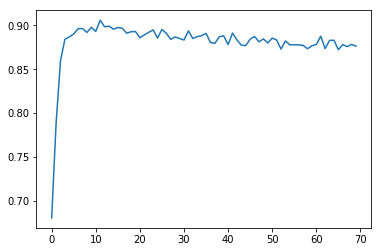

In [191]:
plt.plot(rf_rfe.grid_scores_)

In [267]:
rf_cols = set(X_train.columns[rf_rfe.support_])

In [204]:
F, P_val = f_classif(X_train.values, y_train.values)

In [206]:
idx = np.argsort(P_val)

In [306]:
raw_p_cols = X_train.columns[(P_val < 0.05)]

In [308]:
bonferroni_p_cols = X_train.columns[(P_val < 0.05/X_train.shape[1])]

In [309]:
raw_p_cols.shape, bonferroni_p_cols.shape

((62,), (22,))

## RFE: LogisticRegression

In [220]:
lr_rfe = RFECV(LogisticRegression(), step=2, scoring='roc_auc', cv=five10k, verbose=1, n_jobs=-1)

In [221]:
lr_rfe.fit(X_train, y_train)

Fitting estimator with 138 features.
Fitting estimator with 138 features.
Fitting estimator with 138 features.
Fitting estimator with 138 features.
Fitting estimator with 136 features.
Fitting estimator with 136 features.
Fitting estimator with 136 features.
Fitting estimator with 136 features.
Fitting estimator with 134 features.
Fitting estimator with 134 features.
Fitting estimator with 134 features.
Fitting estimator with 134 features.
Fitting estimator with 132 features.
Fitting estimator with 132 features.
Fitting estimator with 130 features.
Fitting estimator with 132 features.
Fitting estimator with 128 features.
Fitting estimator with 132 features.
Fitting estimator with 130 features.
Fitting estimator with 130 features.
Fitting estimator with 130 features.
Fitting estimator with 126 features.
Fitting estimator with 128 features.
Fitting estimator with 124 features.
Fitting estimator with 128 features.
Fitting estimator with 128 features.
Fitting estimator with 126 features.
F

RFECV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x7f11e23c26a0>,
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
   n_jobs=-1, scoring='roc_auc', step=2, verbose=1)

In [223]:
lr_rfe.n_features_

30

In [265]:
lr_cols = set(X_train.columns[lr_rfe.get_support()])

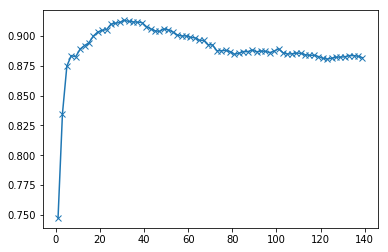

In [246]:
plt.plot(np.arange(X_train.shape[1]+1, 0, -2)[::-1], lr_rfe.grid_scores_, 'x-')

## RFE: LDA

In [259]:
lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

lda_rfe = RFECV(lda, step=1, cv=five10k, scoring='roc_auc', n_jobs=-1, verbose=1)

In [260]:
lda_rfe.fit(X_train, y_train)

Fitting estimator with 138 features.
Fitting estimator with 138 features.
Fitting estimator with 138 features.
Fitting estimator with 138 features.
Fitting estimator with 137 features.
Fitting estimator with 136 features.
Fitting estimator with 135 features.
Fitting estimator with 134 features.
Fitting estimator with 137 features.
Fitting estimator with 137 features.
Fitting estimator with 137 features.
Fitting estimator with 136 features.
Fitting estimator with 136 features.
Fitting estimator with 133 features.
Fitting estimator with 135 features.
Fitting estimator with 136 features.
Fitting estimator with 134 features.
Fitting estimator with 135 features.
Fitting estimator with 132 features.
Fitting estimator with 135 features.
Fitting estimator with 134 features.
Fitting estimator with 133 features.
Fitting estimator with 131 features.
Fitting estimator with 133 features.
Fitting estimator with 132 features.
Fitting estimator with 134 features.
Fitting estimator with 130 features.
F

RFECV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x7f11e23c26a0>,
   estimator=LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage='auto',
              solver='lsqr', store_covariance=False, tol=0.0001),
   n_jobs=-1, scoring='roc_auc', step=1, verbose=1)

In [261]:
lda_rfe.n_features_

64

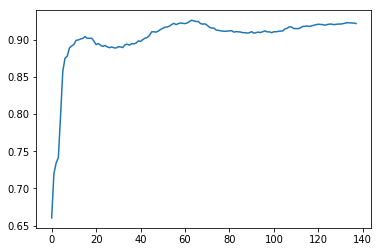

In [262]:
plt.plot(lda_rfe.grid_scores_)

In [266]:
lda_cols = set(X_train.columns[lda_rfe.get_support()])

### RFE: SVM

In [294]:
svm_grid = GridSearchCV(SVC(kernel='linear'), {'C':np.exp2(np.arange(-9, 2))}, cv=k10, scoring='roc_auc', n_jobs=-1)

In [295]:
svm_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.95312e-03,   3.90625e-03,   7.81250e-03,   1.56250e-02,
         3.12500e-02,   6.25000e-02,   1.25000e-01,   2.50000e-01,
         5.00000e-01,   1.00000e+00,   2.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [296]:
svm_grid.best_params_, svm_grid.best_score_

({'C': 0.125}, 0.90003179942337042)

In [297]:
svm_rfe = RFECV(svm_grid.best_estimator_, step=1, cv=five10k, scoring='roc_auc', verbose=1, n_jobs=-1)

In [298]:
svm_rfe.fit(X_train, y_train)

Fitting estimator with 138 features.
Fitting estimator with 138 features.
Fitting estimator with 138 features.
Fitting estimator with 138 features.
Fitting estimator with 137 features.
Fitting estimator with 137 features.
Fitting estimator with 137 features.
Fitting estimator with 137 features.
Fitting estimator with 136 features.
Fitting estimator with 136 features.
Fitting estimator with 135 features.
Fitting estimator with 134 features.
Fitting estimator with 136 features.
Fitting estimator with 133 features.
Fitting estimator with 132 features.
Fitting estimator with 135 features.
Fitting estimator with 131 features.
Fitting estimator with 130 features.
Fitting estimator with 129 features.
Fitting estimator with 128 features.
Fitting estimator with 136 features.
Fitting estimator with 134 features.
Fitting estimator with 135 features.
Fitting estimator with 133 features.
Fitting estimator with 132 features.
Fitting estimator with 127 features.
Fitting estimator with 131 features.
F

RFECV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x7f11e23c26a0>,
   estimator=SVC(C=0.125, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
   n_jobs=-1, scoring='roc_auc', step=1, verbose=1)

In [299]:
svm_rfe.n_features_

25

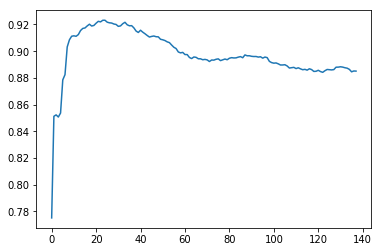

In [300]:
plt.plot(svm_rfe.grid_scores_)

In [301]:
svm_cols = set(X_train.columns[svm_rfe.support_])

In [305]:
svm_cols & rf_cols

{'Ab_42',
 'Cystatin_C',
 'Fibrinogen',
 'MCP_2',
 'MMP10',
 'NT_proBNP',
 'PAI_1',
 'Pancreatic_polypeptide',
 'TRAIL_R3',
 'VEGF',
 'p_tau',
 'tau'}

In [311]:
scores = cross_val_score(lda, X_train[raw_p_cols], y_train, cv=k10, scoring='roc_auc')

scores.mean(), scores.std()

(0.92648966165413538, 0.062916204395573133)

In [312]:
scores = cross_val_score(lda, X_train[bonferroni_p_cols], y_train, cv=k10, scoring='roc_auc')

scores.mean(), scores.std()

(0.88753759398496235, 0.055918769303229601)

In [313]:
X_train[bonferroni_p_cols].corr()

,Creatine_Kinase_MB,Eotaxin_3,FAS,Fibrinogen,GRO_alpha,Gamma_Interferon_induced_Monokin,IGF_BP_2,MCP_2,MIF,MMP10,...,PAI_1,Pancreatic_polypeptide,Resistin,TNF_RII,TRAIL_R3,Thymus_Expressed_Chemokine_TECK,age,tau,p_tau,Ab_42
Creatine_Kinase_MB,1.000000,-0.203245,-0.152187,-0.152903,-0.140777,-0.106677,-0.245850,-0.108028,-0.299396,-0.029866,...,-0.081532,-0.126273,-0.002951,-0.197532,-0.270403,-0.105905,-0.156158,-0.257365,-0.241101,0.016942
Eotaxin_3,-0.203245,1.000000,0.571821,0.373740,0.286983,0.371078,0.716481,0.212490,0.401231,0.409480,...,0.429753,0.207276,0.429175,0.565302,0.428468,0.363181,0.355896,0.378771,0.350015,0.042168
FAS,-0.152187,0.571821,1.000000,0.344293,0.353466,0.439077,0.527331,0.293881,0.561745,0.521905,...,0.429262,0.250979,0.446832,0.673779,0.605786,0.708071,0.333153,0.479596,0.465575,0.006946
Fibrinogen,-0.152903,0.373740,0.344293,1.000000,0.275738,0.418663,0.401626,0.230376,0.149323,0.382616,...,0.405149,0.315354,0.484283,0.380634,0.295087,0.274320,0.287559,0.233023,0.237831,-0.043442
GRO_alpha,-0.140777,0.286983,0.353466,0.275738,1.000000,0.370064,0.268403,0.328994,0.345347,0.445916,...,0.449484,0.279151,0.335667,0.406118,0.383321,0.342281,0.303620,0.355983,0.352900,-0.113112
Gamma_Interferon_induced_Monokin,-0.106677,0.371078,0.439077,0.418663,0.370064,1.000000,0.476997,0.417167,0.317973,0.400860,...,0.549703,0.356227,0.475956,0.536953,0.436598,0.359076,0.595722,0.286715,0.277853,-0.045996
IGF_BP_2,-0.245850,0.716481,0.527331,0.401626,0.268403,0.476997,1.000000,0.281768,0.470005,0.449322,...,0.481457,0.294756,0.404561,0.650924,0.505843,0.358078,0.370750,0.467882,0.467256,0.059785
MCP_2,-0.108028,0.212490,0.293881,0.230376,0.328994,0.417167,0.281768,1.000000,0.216164,0.186361,...,0.147907,0.112336,0.298891,0.242945,0.323699,0.318639,0.195783,0.091624,0.120182,-0.121268
MIF,-0.299396,0.401231,0.561745,0.149323,0.345347,0.317973,0.470005,0.216164,1.000000,0.302866,...,0.293268,0.188906,0.244362,0.550950,0.529458,0.510403,0.348631,0.557659,0.564085,-0.004027
MMP10,-0.029866,0.409480,0.521905,0.382616,0.445916,0.400860,0.449322,0.186361,0.302866,1.000000,...,0.508004,0.300777,0.452419,0.518109,0.409178,0.368410,0.353522,0.471844,0.424182,-0.109170


In [316]:
roc_auc_score(y_test, 
              lda.fit(X_train[raw_p_cols], y_train).predict_proba(X_test[raw_p_cols])[:, 1])

0.90022675736961455

In [317]:
roc_auc_score(y_test, 
              lda.fit(X_train[bonferroni_p_cols], y_train).predict_proba(X_test[bonferroni_p_cols])[:, 1])

0.79818594104308394

In [319]:
fpr_selector = SelectFpr()

In [320]:
fpr_selector.fit(X_train, y_train)

SelectFpr(alpha=0.05, score_func=<function f_classif at 0x7f11fb6f7048>)

In [322]:
fpr_selector.transform(X_train).shape

(266, 62)